**Download the dataset**

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("gpiosenka/sports-classification")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/sports-classification


Download libreries

In [6]:
!pip install -Uqq fastai 'duckduckgo_search>=6.2'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 46.1 MB/s eta 0:00:0000:0100:01


In [12]:
!mkdir -p /kaggle/ai_test/sports/golf
!cp /kaggle/input/sports-classification/train/golf/*.* /kaggle/ai_test/sports/golf/

In [13]:
!mkdir -p /kaggle/ai_test/sports/basketball
!cp /kaggle/input/sports-classification/train/basketball/*.* /kaggle/ai_test/sports/basketball/

In [14]:
!mkdir -p /kaggle/ai_test/sports/boxing
!cp /kaggle/input/sports-classification/train/boxing/*.* /kaggle/ai_test/sports/boxing/

In [15]:
!ls /kaggle/ai_test/sports

basketball  boxing  golf


In [16]:
from fastcore.all import *
from fastai.vision.all import *

In [17]:
sport_types = 'basketball', 'boxing', 'golf'
path = Path('/kaggle/ai_test/sports')

This command has given us a DataBlock object. This is like a template for creating a DataLoaders. We still need to tell fastai the actual source of our data—in this case, the path where the images can be found:

In [18]:
sports = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

We need to tell fastai the actual source of our data—in this case, the path where the images can be found

In [19]:
dls = sports.dataloaders(path)

A DataLoaders includes validation and training DataLoaders. DataLoader is a class that provides batches of a few items at a time to the GPU. We'll be learning a lot more about this class in the next chapter. When you loop through a DataLoader fastai will give you 64 (by default) items at a time, all stacked up into a single tensor. We can take a look at a few of those items by calling the show_batch method on a DataLoader:

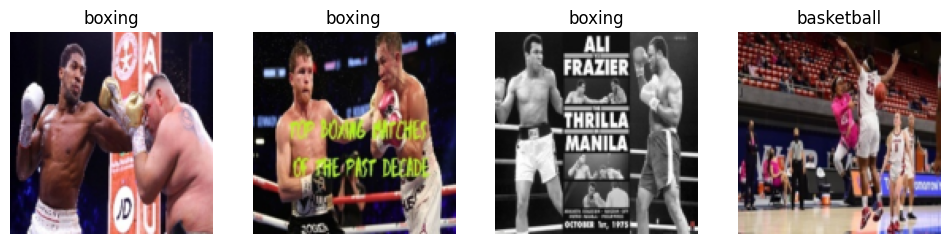

In [20]:
dls.valid.show_batch(max_n=4, nrows=1)

By default Resize crops the images to fit a square shape of the size requested, using the full width or height. This can result in losing some important details. Alternatively, you can ask fastai to pad the images with zeros (black), or squish/stretch them:

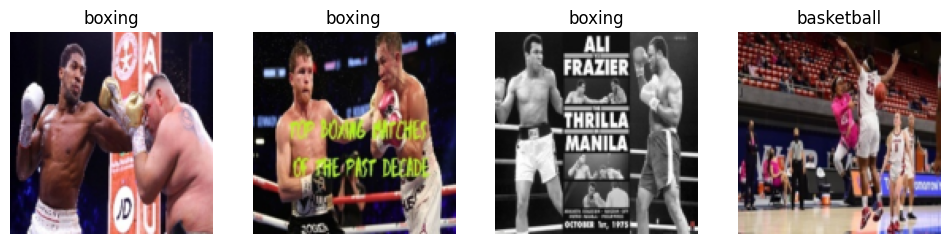

In [21]:
sports = sports.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = sports.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

Here's another example where we replace Resize with RandomResizedCrop, which is the transform that provides the behavior we just described. The most important parameter to pass in is min_scale, which determines how much of the image to select at minimum each time:

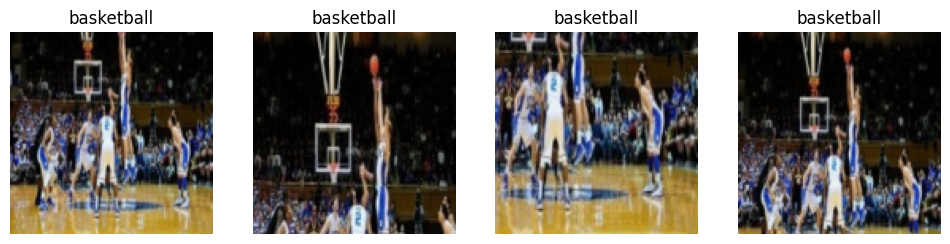

In [22]:

sports = sports.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = sports.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

**Data Augmentation**
Data augmentation refers to creating random variations of our input data, such that they appear different, but do not actually change the meaning of the data. Examples of common data augmentation techniques for images are rotation, flipping, perspective warping, brightness changes and contrast changes. For natural photo images such as the ones we are using here, a standard set of augmentations that we have found work pretty well are provided with the aug_transforms function. Because our images are now all the same size, we can apply these augmentations to an entire batch of them using the GPU, which will save a lot of time. To tell fastai we want to use these transforms on a batch, we use the batch_tfms parameter (note that we're not using RandomResizedCrop in this example, so you can see the differences more clearly; we're also using double the amount of augmentation compared to the default, for the same reason):

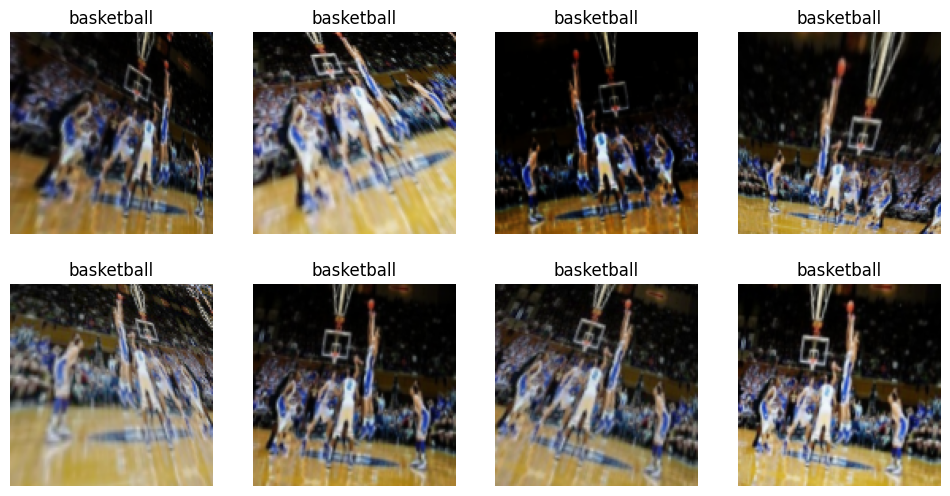

In [23]:
sports = sports.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = sports.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

**Training Model, and Using It to Clean Your Data**
Time to use the same lines of code as in <<chapter_intro>> to train our bear classifier.

We don't have a lot of data for our problem (150 pictures of each sort of bear at most), so to train our model, we'll use RandomResizedCrop with an image size of 224 px, which is fairly standard for image classification, and default aug_transforms:

In [24]:
sports = sports.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = sports.dataloaders(path)

**now create our Learner and fine-tune it in the usual way:**

Try to plot the loss for training set .... Check with Marcin later... Check with other ref

In [25]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(10)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 168MB/s] 


epoch,train_loss,valid_loss,error_rate,time
0,1.411201,1.100644,0.363636,00:03


epoch,train_loss,valid_loss,error_rate,time
0,0.383783,0.474983,0.159091,00:02
1,0.316610,0.165186,0.056818,00:02
2,0.243133,0.086596,0.034091,00:02
3,0.194043,0.083416,0.034091,00:02
4,0.162594,0.084028,0.022727,00:02
5,0.136607,0.085206,0.022727,00:02
6,0.118583,0.089250,0.034091,00:02
7,0.100656,0.089364,0.034091,00:02
8,0.088029,0.091227,0.034091,00:02
9,0.081836,0.092195,0.034091,00:01


**confusion matrix:**

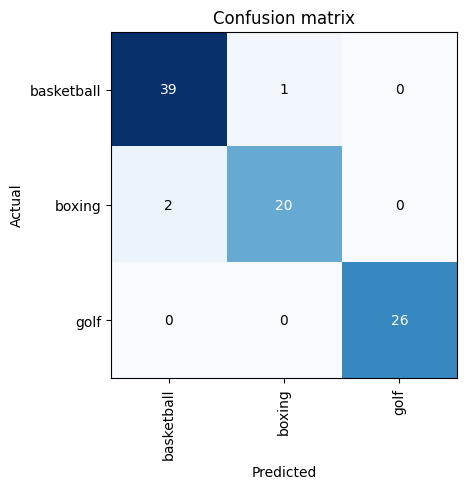

In [26]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

The loss is a number that is higher if the model is incorrect (especially if it's also confident of its incorrect answer), or if it's correct, but not confident of its correct answer. In a couple of chapters we'll learn in depth how loss is calculated and used in the training process. For now, plot_top_losses shows us the images with the highest loss in our dataset. As the title of the output says, each image is labeled with four things: prediction, actual (target label), loss, and probability. The probability here is the confidence level, from zero to one, that the model has assigned to its prediction:

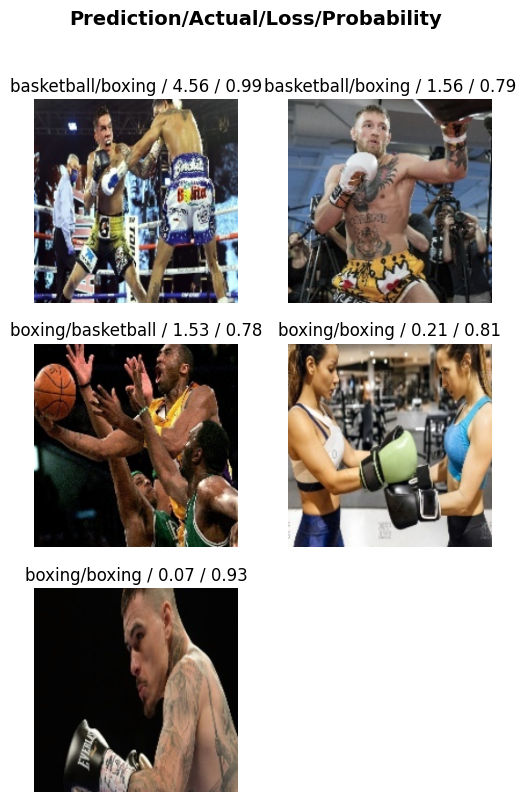

In [27]:
interp.plot_top_losses(5, nrows=3)

fastai includes a handy GUI for data cleaning called ImageClassifierCleaner that allows you to choose a category and the training versus validation set and view the highest-loss images (in order), along with menus to allow images to be selected for removal or relabeling:

In [28]:
#hide_output
from fastai.vision.widgets import ImageClassifierCleaner

cleaner = ImageClassifierCleaner(learn)
cleaner

**Using the Model for Inference**
Once you've got a model you're happy with, you need to save it, so that you can then copy it over to a server where you'll use it in production. Remember that a model consists of two parts: the architecture and the trained parameters. The easiest way to save the model is to save both of these, because that way when you load a model you can be sure that you have the matching architecture and parameters. To save both parts, use the export method.

This method even saves the definition of how to create your DataLoaders. This is important, because otherwise you would have to redefine how to transform your data in order to use your model in production. fastai automatically uses your validation set DataLoader for inference by default, so your data augmentation will not be applied, which is generally what you want.

When you call export, fastai will save a file called "export.pkl":

In [30]:
learn.export()

In [31]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [ ]:
!ls -l {path}

When we use a model for getting predictions, instead of training, we call it inference. To create our inference learner from the exported file, we use load_learner (in this case, this isn't really necessary, since we already have a working Learner in our notebook; we're just doing it here so you can see the whole process end-to-end):

In [33]:
learn_inf = load_learner(path/'export.pkl')

In [34]:
!ls -l /kaggle/input/validation

total 152
-rw-r--r-- 1 nobody nogroup 152972 Jan 30 19:40 cover_golf-1.jpg


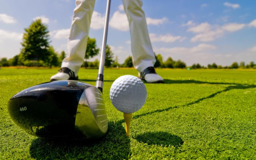

In [36]:
im = Image.open('/kaggle/input/validation/cover_golf-1.jpg')
im.to_thumb(256,256)

In [37]:
learn_inf.predict('/kaggle/input/validation/cover_golf-1.jpg')

('golf', tensor(2), tensor([3.0225e-06, 3.0912e-06, 9.9999e-01]))

In [38]:
learn_inf.dls.vocab

['basketball', 'boxing', 'golf']

In [40]:
import ipywidgets as widgets
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value=(), description='Upload')

In [41]:
print(btn_upload.value)

({'name': 'GJ__1616-2.jpg', 'type': 'image/jpeg', 'size': 1972097, 'content': <memory at 0x7cd0141fa200>, 'last_modified': datetime.datetime(2025, 1, 30, 19, 48, 49, 210000, tzinfo=datetime.timezone.utc)},)


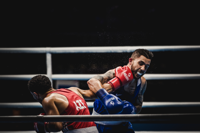

In [47]:
from PIL import Image
from io import BytesIO
import IPython.display as display

# Ensure files were uploaded
if btn_upload.value:
    for uploaded_file in btn_upload.value:
        image = Image.open(BytesIO(uploaded_file['content']))  # Open the image
        display.display(image.to_thumb(200,200))  # Display image in notebook
else:
    print("No file uploaded.")

In [48]:
#Get predictions
pred,pred_idx,probs = learn_inf.predict(image)

In [49]:
#and use a Label to display them:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: boxing; Probability: 1.0000')

In [63]:
def on_click_classify(change):
    if btn_upload.value:
        for uploaded_file in btn_upload.value:
            image = Image.open(BytesIO(uploaded_file['content']))  # Open the image
            #display.display(image.to_thumb(200,200))  # Display image in notebook
    else:
        print("No file uploaded.")
    out_pl.clear_output()
    with out_pl:
        display.display(image.to_thumb(200,200))
    pred,pred_idx,probs = learn_inf.predict(image)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'


In [64]:
out_pl = widgets.Output()
btn_run = widgets.Button(description='Classify')
btn_run
btn_run.on_click(on_click_classify)
btn_upload = widgets.FileUpload()

In [65]:
from ipywidgets import VBox, Label
VBox([widgets.Label('Select your Sports!'), 
      btn_upload, btn_run, out_pl, lbl_pred])